# This notebook consists of steps that are used to preprocess using Ketos library.

###Downloading and unzipping the files from the data sources that contain the calls of the SRKW

In [ ]:
%%bash
apt-get install awscli
aws --no-sign-request s3 cp s3://acoustic-sandbox/labeled-data/detection/train/OrcasoundLab07052019_PodCastRound2.tar.gz /content
aws --no-sign-request s3 cp s3://acoustic-sandbox/labeled-data/detection/train/OrcasoundLab09272017_PodCastRound3.tar.gz /content
aws --no-sign-request s3 cp s3://acoustic-sandbox/labeled-data/detection/test/OrcasoundLab09272017_Test.tar.gz /content

tar -xzvf/content/OrcasoundLab09272017_PodCastRound3.tar.gz 
tar -xzvf/content/OrcasoundLab07052019_PodCastRound2.tar.gz
tar -xzvf/content/OrcasoundLab09272017_Test.tar.gz


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  docutils-common python3-botocore python3-certifi python3-chardet
  python3-colorama python3-dateutil python3-docutils python3-idna
  python3-jmespath python3-olefile python3-pil python3-pkg-resources
  python3-pyasn1 python3-pygments python3-requests python3-roman python3-rsa
  python3-s3transfer python3-six python3-urllib3 python3-yaml sgml-base
  xml-core
Suggested packages:
  docutils-doc fonts-linuxlibertine | ttf-linux-libertine texlive-lang-french
  texlive-latex-base texlive-latex-recommended python-pil-doc python3-pil-dbg
  python3-setuptools ttf-bitstream-vera python3-cryptography python3-openssl
  python3-socks sgml-base-doc debhelper
The following NEW packages will be installed:
  awscli docutils-common python3-botocore python3-certifi python3-chardet
  python3-colorama python3-dateutil python3-docutils python3-idna
  python3-jmespath pytho

In [ ]:
!pip install pysoundfile
!pip install ketos==2.0.0b4


     |████████████████████████████████| 122kB 11.3MB/s 
     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 194kB 58.4MB/s 
     |████████████████████████████████| 3.9MB 44.7MB/s 
     |████████████████████████████████| 450kB 55.5MB/s 
  Created wheel for ketos: filename=ketos-2.0.0b4-cp36-none-any.whl size=157685 sha256=5f18ec473f9d8e9ce5182e6d8fea6c6e326f801f5cb3d3b37f63b1ac96d50438
  Stored in directory: /root/.cache/pip/wheels/56/3e/f7/9ed88728ecbb790fc6b6153d70c6ce7ff9d8f5e5ab59b76a20
  Created wheel for datetime-glob: filename=datetime_glob-1.0.7-cp36-none-any.whl size=7389 sha256=823b38571f04c578fe950cf99aa6d27f7d4b17a00b571539df924627900d3f03
  Stored in directory: /root/.cache/pip/wheels/0f/86/c9/de310d166ddb2d6a52628685544c48fd5a167a3ac3dd441809
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=98c3a3e3373f5aa403f0aebe4cae887f200cdf2e220964e1600946730c5fbef5
  Stored in directory: /root/.cache/pip/whee

### Importing the necessary files

In [ ]:
import pandas as pd
from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.audio.spectrogram import MagSpectrogram
from ketos.data_handling.parsing import load_audio_representation
from scipy.io.wavfile import read as read_wav
import os

####The tsv files contains the parameters like start_time,duration_s,etc, but since these are not in the format Ketos accepts,we need to perform some changes in labels and therefore these files have been uploaded from the local machine


In [ ]:
#Function to add the end time
def add_end(filename):
    filename["end"]=filename["start"]+filename["duration_s"]

In [ ]:
#Generate mean and annot-train
def duration_mean(filename):
    annot_train = pd.read_csv(filename, sep='\t')
    mean=annot_train['duration_s'].mean()
    return annot_train,mean
  

In [ ]:
annot_train2,mean2=duration_mean('/content/podcast2.tsv')
annot_train3,mean3 = duration_mean('/content/podcast3.tsv')
annot_test,mean_test = duration_mean('/content/v10_test.tsv')
annot_val,mean_val=pd.read_csv('/content/train_pod22.tsv', sep='\t')

print(mean2)
annot_train2.head()


2.1110548004254963


,wav_filename,start,duration_s,location,date,data_source,data_source_id,label
0,1562337136_0004.wav,49.765625,2.450000,orcasound_lab,2019-07-05,Orcasound_PodCast_Round2,1562337136,SRKWs
1,1562337136_0004.wav,41.046007,1.658854,orcasound_lab,2019-07-05,Orcasound_PodCast_Round2,1562337136,SRKWs
2,1562337136_0004.wav,37.345486,1.743924,orcasound_lab,2019-07-05,Orcasound_PodCast_Round2,1562337136,SRKWs
3,1562337136_0004.wav,42.917535,2.594618,orcasound_lab,2019-07-05,Orcasound_PodCast_Round2,1562337136,SRKWs
4,1562337136_0004.wav,45.980035,2.041667,orcasound_lab,2019-07-05,Orcasound_PodCast_Round2,1562337136,SRKWs


####Here is how the .tsv files and their labels look like when they are in format that could be accepted by ketos

In [ ]:
add_end(annot_train2)
add_end(annot_train3)
add_end(annot_test)
add_end(annot_val)
annot_train2.head()

,wav_filename,start,duration_s,location,date,data_source,data_source_id,label,end
0,1562337136_0004.wav,49.765625,2.450000,orcasound_lab,2019-07-05,Orcasound_PodCast_Round2,1562337136,SRKWs,52.215625
1,1562337136_0004.wav,41.046007,1.658854,orcasound_lab,2019-07-05,Orcasound_PodCast_Round2,1562337136,SRKWs,42.704861
2,1562337136_0004.wav,37.345486,1.743924,orcasound_lab,2019-07-05,Orcasound_PodCast_Round2,1562337136,SRKWs,39.089410
3,1562337136_0004.wav,42.917535,2.594618,orcasound_lab,2019-07-05,Orcasound_PodCast_Round2,1562337136,SRKWs,45.512153
4,1562337136_0004.wav,45.980035,2.041667,orcasound_lab,2019-07-05,Orcasound_PodCast_Round2,1562337136,SRKWs,48.021701


###Standardizing the tsv files

In [ ]:
map_to_ketos_annot_std ={'wav_filename': 'filename'} 
std_annot_train2 = sl.standardize(table=annot_train2, signal_labels=["SRKWs"], mapper=map_to_ketos_annot_std, trim_table=True)
std_annot_train3 = sl.standardize(table=annot_train3, signal_labels=["SRKWs"], mapper=map_to_ketos_annot_std, trim_table=True)
std_annot_val = sl.standardize(table=annot_val, signal_labels=["SRKWs"], mapper=map_to_ketos_annot_std, trim_table=True)

std_annot_test = sl.standardize(table=annot_test, signal_labels=["SRKWs"], mapper=map_to_ketos_annot_std, trim_table=True)


In [ ]:
std_annot_train2


start  label        end
filename            annot_id                             
1562337136_0004.wav 0         49.765625      1  52.215625
                    1         41.046007      1  42.704861
                    2         37.345486      1  39.089410
                    3         42.917535      1  45.512153
                    4         45.980035      1  48.021701
...                                 ...    ...        ...
1562344334_000e.wav 4         29.699870      1  31.805339
                    5         43.895833      1  46.384115
                    6         54.295573      1  56.273438
1562344334_000f.wav 0          7.440918      1   9.546387
1562344334_001c.wav 0         31.534653      1  33.700495

[357 rows x 3 columns]

In [ ]:
annot_id2 = pd.read_csv('/content/std_annot_train2_final.tsv', sep='\t')


### We are going to use Magnitude Spectrogram as shown below for training

In [ ]:
spec = MagSpectrogram.from_wav('/content/Round2_OS_07_05/wav/1562337136_0004.wav', window=2, step=0.01, offset=3.0, duration=3.0,rate=20000) #spect

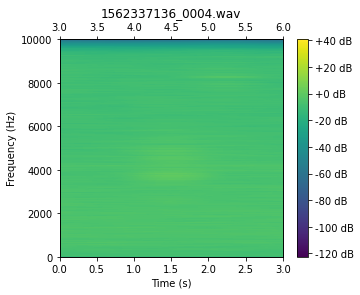

In [ ]:
fig2 = spec.plot(label_in_title=False, show_annot=False)

In [ ]:
std_annot_val

start  label        end
filename                        annot_id                             
OS_9_27_2017_08_09_00__0002.wav 0         10.378472      1  11.824653
                                1         11.697049      1  12.675347
                                2         18.204861      1  19.268229
                                3         15.993056      1  17.184028
                                4         35.686632      1  37.005208
                                5         56.741319      1  58.910590
OS_9_27_2017_08_09_00__0004.wav 0         24.500000      1  26.950000
                                1         21.565104      1  23.096354
                                2         27.902778      1  29.221354
                                3         51.637153      1  53.466146
                                4         58.102431      1  59.931424
OS_9_27_2017_08_14_00__0000.wav 0          7.694531      1   9.594238
                                1         26.016895      1  27.749121
                                2         13.518066      1  15.384277
                                3         16.437012      1  17.824707
                                4         18.398926      1  20.193359
                                5         21.341797      1  24.452148
                                6         30.313965      1  31.558105
                                7         32.491211      1  33.759277
                                8         53.617676      1  55.507812
                                9         58.283203      1  60.962891

#### Loading the .json file which contains the parameters to be used for generating spectrograms and storing into the .h5 file

In [ ]:
spec_cfg = load_audio_representation('/content/spec_config.json', name="spectrogram")


In [ ]:
spec_cfg2 = load_audio_representation('/spec2.json', name="spectrogram")


In [ ]:
spec_cfg

{'freq_max': 15000,
 'freq_min': 500,
 'rate': 20000,
 'step': 0.032,
 'type': 'MagSpectrogram',
 'window': 0.256,
 'window_func': 'hamming'}

In [ ]:
positives_train2 = sl.select(annotations=std_annot_train2, length=3.0)
positives_train2


label      start        end
filename            sel_id                             
1562337136_0004.wav 0           1  49.372490  52.372490
                    1           1  40.390361  43.390361
                    2           1  36.481965  39.481965
                    3           1  42.559969  45.559969
                    4           1  45.358154  48.358154
...                           ...        ...        ...
1562344334_000e.wav 4           1  28.805671  31.805671
                    5           1  43.731572  46.731572
                    6           1  53.284509  56.284509
1562344334_000f.wav 0           1   7.053610  10.053610
1562344334_001c.wav 0           1  30.874200  33.874200

[357 rows x 3 columns]

Adding the podcast 3 files as well and would be performing same procedure and then combine both to the h5 file


In [ ]:
file_durations_train2 = sl.file_duration_table('/content/Round2_OS_07_05/wav')
file_durations_train2

,filename,duration
0,1562337136_0004.wav,61.2
1,1562337136_0005.wav,61.2
2,1562337136_0006.wav,61.2
3,1562337136_000a.wav,61.2
4,1562337136_000b.wav,61.2
5,1562337136_000c.wav,61.2
6,1562337136_000d.wav,61.2
7,1562337136_000e.wav,61.2
8,1562337136_0010.wav,61.2
9,1562337136_0012.wav,61.2


### Generating a .tsv file that would contain the negative calls start time and end time and using this generated tsv we would extract negative calls from the audio files

In [ ]:
negatives_train2=sl.create_rndm_backgr_selections(annotations=std_annot_train2, files=file_durations_train2, length=3.0, num=len(positives_train2), trim_table=True)
negatives_train2

start        end  label
filename            sel_id                             
1562337136_0004.wav 0        3.037817   6.037817      0
                    1        8.755218  11.755218      0
                    2        9.866573  12.866573      0
                    3       20.286421  23.286421      0
                    4       22.832161  25.832161      0
...                               ...        ...    ...
1562344334_001c.wav 4       18.508122  21.508122      0
                    5       25.352299  28.352299      0
                    6       39.892849  42.892849      0
                    7       45.466822  48.466822      0
                    8       54.694660  57.694660      0

[357 rows x 3 columns]

In [ ]:
selections_train2 = positives_train2.append(negatives_train2, sort=False)


#### Determining the sampling rate

In [ ]:
os.chdir('/content/Round2_OS_07_05/wav') # change to the file directory
sampling_rate, data=read_wav("1562337136_0017.wav") # enter your filename
print(sampling_rate)

20000


#### Since we are in the Round2 directory we want to change it to the base directory since we want to save our .h5 file over that which we would generate in the below steps

In [ ]:
!pwd
%cd ../      
%cd ../
!pwd

/content/Round2_OS_07_05
/content
/
/


### This is the step where we would generate the hdf5 file which contains spectrogram data in the form of numpy array. The spectrograms are generated using the parameters specified in the spec_cfg file i.e the .json file that we passed stating the max_frequency, min_frequency, sampling_rate, etc 

In [ ]:
dbi.create_database(output_file='train_database.h5', data_dir='/content/Round2_OS_07_05/wav',
                               dataset_name='wav',selections=selections_train2,
                               audio_repres=spec_cfg)
                              




  0%|          | 0/714 [00:00<?, ?it/s]


  0%|          | 1/714 [00:00<05:49,  2.04it/s]


  0%|          | 2/714 [00:00<05:41,  2.08it/s]


  0%|          | 3/714 [00:01<05:45,  2.06it/s]


  1%|          | 4/714 [00:01<05:43,  2.07it/s]


  1%|          | 5/714 [00:02<05:42,  2.07it/s]


  1%|          | 6/714 [00:02<05:39,  2.09it/s]


  1%|          | 7/714 [00:03<05:43,  2.06it/s]


  1%|          | 8/714 [00:03<05:31,  2.13it/s]


  1%|▏         | 9/714 [00:04<05:34,  2.11it/s]


  1%|▏         | 10/714 [00:04<05:35,  2.10it/s]


  2%|▏         | 11/714 [00:05<05:35,  2.09it/s]


  2%|▏         | 12/714 [00:05<05:38,  2.08it/s]


  2%|▏         | 13/714 [00:06<05:38,  2.07it/s]


  2%|▏         | 14/714 [00:06<05:36,  2.08it/s]


  2%|▏         | 15/714 [00:07<05:35,  2.08it/s]


  2%|▏         | 16/714 [00:07<05:33,  2.09it/s]


  2%|▏         | 17/714 [00:08<05:30,  2.11it/s]


  3%|▎         | 18/714 [00:08<05:30,  2.11it/s]


  3%|▎         | 19/714 [00:09<05:28,  2.12it/

714 items saved to train_database.h5


#### Doing the same for Round3 data and generating the negative calls


In [ ]:
positives_train3 = sl.select(annotations=std_annot_train3, length=3.0)
file_durations_train3 = sl.file_duration_table('/content/Round3_OS_09_27_2017/wav')
negatives_train3=sl.create_rndm_backgr_selections(annotations=std_annot_train3, files=file_durations_train3, length=3.0, num=len(positives_train3), trim_table=True)
selections_train3 = positives_train3.append(negatives_train3, sort=False)



#### Saving the negative calls to the database i.e the hdf5 file. Now we have both the spectrogram data for positive and negative samples

In [ ]:
dbi.create_database(output_file='train_database.h5', data_dir='/content/Round3_OS_09_27_2017/wav',
                               dataset_name='wav',selections=selections_train3,
                               audio_repres=spec_cfg)
                              




  0%|          | 0/950 [00:00<?, ?it/s]


  0%|          | 1/950 [00:00<05:58,  2.65it/s]


  0%|          | 2/950 [00:00<06:01,  2.63it/s]


  0%|          | 3/950 [00:01<06:07,  2.57it/s]


  0%|          | 4/950 [00:01<06:19,  2.50it/s]


  1%|          | 5/950 [00:01<06:16,  2.51it/s]


  1%|          | 6/950 [00:02<06:24,  2.46it/s]


  1%|          | 7/950 [00:02<06:30,  2.42it/s]


  1%|          | 8/950 [00:03<06:46,  2.32it/s]


  1%|          | 9/950 [00:03<06:51,  2.28it/s]


  1%|          | 10/950 [00:04<06:46,  2.31it/s]


  1%|          | 11/950 [00:04<06:46,  2.31it/s]


  1%|▏         | 12/950 [00:05<06:48,  2.29it/s]


  1%|▏         | 13/950 [00:05<06:47,  2.30it/s]


  1%|▏         | 14/950 [00:05<06:52,  2.27it/s]


  2%|▏         | 15/950 [00:06<07:00,  2.23it/s]


  2%|▏         | 16/950 [00:06<06:52,  2.26it/s]


  2%|▏         | 17/950 [00:07<06:55,  2.24it/s]


  2%|▏         | 18/950 [00:07<06:53,  2.25it/s]


  2%|▏         | 19/950 [00:08<06:55,  2.24it/

950 items saved to train_database.h5


### Performing the same process for validation data

In [ ]:

positives_val = sl.select(annotations=std_annot_val, length=3.0)
file_durations_val = sl.file_duration_table('/content/val_data')
negatives_val=sl.create_rndm_backgr_selections(annotations=std_annot_val, files=file_durations_val, length=3.0, num=len(positives_val), trim_table=True)
selections_val = positives_val.append(negatives_val)


In [ ]:

dbi.create_database(output_file='train_database.h5', data_dir='/content/val_data',
                               dataset_name='val3',selections=selections_val,
                               audio_repres=spec_cfg)




  0%|          | 0/42 [00:00<?, ?it/s]


  2%|▏         | 1/42 [00:00<00:18,  2.26it/s]


  5%|▍         | 2/42 [00:00<00:17,  2.27it/s]


  7%|▋         | 3/42 [00:01<00:17,  2.25it/s]


 10%|▉         | 4/42 [00:01<00:16,  2.25it/s]


 12%|█▏        | 5/42 [00:02<00:16,  2.23it/s]


 14%|█▍        | 6/42 [00:02<00:16,  2.17it/s]


 17%|█▋        | 7/42 [00:03<00:16,  2.16it/s]


 19%|█▉        | 8/42 [00:03<00:15,  2.16it/s]


 21%|██▏       | 9/42 [00:04<00:15,  2.15it/s]


 24%|██▍       | 10/42 [00:04<00:14,  2.14it/s]


 26%|██▌       | 11/42 [00:05<00:14,  2.13it/s]


 29%|██▊       | 12/42 [00:05<00:13,  2.17it/s]


 31%|███       | 13/42 [00:05<00:13,  2.21it/s]


 33%|███▎      | 14/42 [00:06<00:12,  2.22it/s]


 36%|███▌      | 15/42 [00:06<00:11,  2.26it/s]


 38%|███▊      | 16/42 [00:07<00:11,  2.28it/s]


 40%|████      | 17/42 [00:07<00:11,  2.26it/s]


 43%|████▎     | 18/42 [00:08<00:10,  2.27it/s]


 45%|████▌     | 19/42 [00:08<00:10,  2.23it/s]


 48%|████▊     

42 items saved to train_database.h5


In [ ]:
db = dbi.open_file("train_database.h5", 'a')


In [ ]:
train_data = dbi.open_table(db, "/wav/data")
val_data = dbi.open_table(db, "/val3/data")

In [ ]:
train_data

/wav/data (Table(1664,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(94, 2433), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (1,)

In [ ]:
db.close()

### Performing the same procedure for the test data as well

In [ ]:
positives_test = sl.select(annotations=std_annot_test, length=3.0)
#positives_train2
file_durations_test = sl.file_duration_table('/content/OrcasoundLab09272017_Test/wav')
negatives_test=sl.create_rndm_backgr_selections(annotations=std_annot_test, files=file_durations_test, length=3.0, num=len(positives_test), trim_table=True)
#negatives_train3
selections_test = positives_test.append(negatives_test, sort=False)



In [ ]:
dbi.create_database(output_file='test_database.h5', data_dir='/content/OrcasoundLab09272017_Test/wav',
                               dataset_name='wav',selections=selections_test,
                               audio_repres=spec_cfg)
                              




  0%|          | 0/226 [00:00<?, ?it/s]


  0%|          | 1/226 [00:00<01:40,  2.25it/s]


  1%|          | 2/226 [00:00<01:38,  2.26it/s]


  1%|▏         | 3/226 [00:01<01:40,  2.23it/s]


  2%|▏         | 4/226 [00:01<01:40,  2.21it/s]


  2%|▏         | 5/226 [00:02<01:37,  2.27it/s]


  3%|▎         | 6/226 [00:02<01:37,  2.26it/s]


  3%|▎         | 7/226 [00:03<01:38,  2.22it/s]


  4%|▎         | 8/226 [00:03<01:41,  2.15it/s]


  4%|▍         | 9/226 [00:04<01:38,  2.19it/s]


  4%|▍         | 10/226 [00:04<01:38,  2.18it/s]


  5%|▍         | 11/226 [00:04<01:37,  2.20it/s]


  5%|▌         | 12/226 [00:05<01:38,  2.17it/s]


  6%|▌         | 13/226 [00:05<01:40,  2.12it/s]


  6%|▌         | 14/226 [00:06<01:40,  2.11it/s]


  7%|▋         | 15/226 [00:06<01:41,  2.08it/s]


  7%|▋         | 16/226 [00:07<01:40,  2.10it/s]


  8%|▊         | 17/226 [00:07<01:36,  2.16it/s]


  8%|▊         | 18/226 [00:08<01:34,  2.21it/s]


  8%|▊         | 19/226 [00:08<01:32,  2.25it/

226 items saved to test_database.h5


In [ ]:
db = dbi.open_file("train_database.h5", 'r')


In [ ]:
train_data = dbi.open_table(db, "/wav/data")


In [ ]:
train_data

/wav/data (Table(1706,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(94, 104), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (6,)

In [ ]:
db.close()

In [ ]:
dbi.create_database(output_file='exp2train_database.h5', data_dir='/content/Round2_OS_07_05/wav',
                               dataset_name='wav',selections=selections_train2,
                               audio_repres=spec_cfg2)
                              




  0%|          | 0/714 [00:00<?, ?it/s]


  0%|          | 1/714 [00:00<05:02,  2.36it/s]


  0%|          | 2/714 [00:00<04:57,  2.39it/s]


  0%|          | 3/714 [00:01<04:55,  2.40it/s]


  1%|          | 4/714 [00:01<05:00,  2.37it/s]


  1%|          | 5/714 [00:02<05:01,  2.36it/s]


  1%|          | 6/714 [00:02<04:57,  2.38it/s]


  1%|          | 7/714 [00:02<04:54,  2.40it/s]


  1%|          | 8/714 [00:03<04:51,  2.43it/s]


  1%|▏         | 9/714 [00:03<04:52,  2.41it/s]


  1%|▏         | 10/714 [00:04<04:51,  2.42it/s]


  2%|▏         | 11/714 [00:04<04:47,  2.45it/s]


  2%|▏         | 12/714 [00:04<04:48,  2.44it/s]


  2%|▏         | 13/714 [00:05<04:48,  2.43it/s]


  2%|▏         | 14/714 [00:05<04:46,  2.45it/s]


  2%|▏         | 15/714 [00:06<04:45,  2.45it/s]


  2%|▏         | 16/714 [00:06<04:45,  2.45it/s]


  2%|▏         | 17/714 [00:07<04:43,  2.46it/s]


  3%|▎         | 18/714 [00:07<04:41,  2.47it/s]


  3%|▎         | 19/714 [00:07<04:40,  2.48it/

714 items saved to exp2train_database.h5


## **The preprocessing ends here**

---

